# Conjugate Priors

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapters we have used grid approximations to solve a variety of problems.
One of my goals has been to show that this approach is sufficient to solve many real-world problems.
And I think it's a good place to start because it shows clearly how the methods work.

However, as we saw in the previous chapter, grid methods will only get you so far.
As we increase the number of parameters, the number of points in the grid grows (literally) exponentially.
With more than 3-4 parameters, grid methods become impractical.

So, in the remaining three chapters, I will present three alternatives:

1. In this chapter we'll use **conjugate priors** to speed up some of the computations we've already done.

2. In the next chapter, I'll present Monte Carlo Markov Chain (MCMC) methods, which can solve problems with tens of parameters, or even hundreds, in a reasonable amount of time.

3. And in the last chapter we'll use Approximate Bayesian Calculation (ABC) for problems that are hard to model with simple distributions.

We'll start with the World Cup problem.

## The World Cup Problem Revisited

In <<_PoissonProcesses>>, we solved the World Cup problem using a Poisson process to model goals in a soccer game as random events that are equally likely to occur at any point during a game.

We used a gamma distribution to represent the prior distribution of $\lambda$, the goal-scoring rate.  And we used a Poisson distribution to compute the probability of $k$, the number of goals scored.

Here's a gamma object that represents the prior distribution.

In [4]:
from scipy.stats import gamma

alpha = 1.4
dist = gamma(alpha)

And here's a grid approximation.

In [5]:
import numpy as np
from utils import pmf_from_dist

lams = np.linspace(0, 10, 101)
prior = pmf_from_dist(dist, lams)

Here's the likelihood of scoring 4 goals for each possible value of `lam`.

In [6]:
from scipy.stats import poisson

k = 4
likelihood = poisson(lams).pmf(k)

And here's the update.

In [7]:
posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

So far, this should be familiar.
Now we'll solve the same problem using the conjugate prior.

## The Conjugate Prior

In <<_TheGammaDistribution>>, I presented three reasons to use a gamma distribution for the prior and said there was a fourth reason I would reveal later.
Well, now is the time.

The other reason I chose the gamma distribution is that it is the "conjugate prior" of the Poisson distribution, so-called because the two distributions are connected or coupled, which is what "conjugate" means.

In the next section I'll explain *how* they are connected, but first I'll show you the consequence of this connection, which is that there is a remarkably simple way to compute the posterior distribution.

However, in order to demonstrate it, we have to switch from the one-parameter version of the gamma distribution to the two-parameter version.  Since the first parameter is called `alpha`, you might guess that the second parameter is called `beta`.

The following function takes `alpha` and `beta` and makes an object that represents a gamma distribution with those parameters.

In [8]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

Here's the prior distribution with `alpha=1.4` again and `beta=1`. 

In [9]:
alpha = 1.4
beta = 1

prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

1.4

Now I claim without proof that we can do a Bayesian update with `k` goals just by making a gamma distribution with parameters `alpha+k` and `beta+1`.

In [10]:
def update_gamma(prior, data):
    """Update a gamma prior."""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)

Here's how we update it with `k=4` goals in `t=1` game.

In [11]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

After all the work we did with the grid, it might seem absurd that we can do a Bayesian update by adding two pairs of numbers.
So let's confirm that it works.

I'll make a `Pmf` with a discrete approximation of the posterior distribution.

In [12]:
posterior_conjugate = pmf_from_dist(posterior_gamma, lams)

The following figure shows the result along with the posterior we computed using the grid algorithm.

In [13]:
from utils import decorate

def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
             ylabel='PMF',
             title=title)

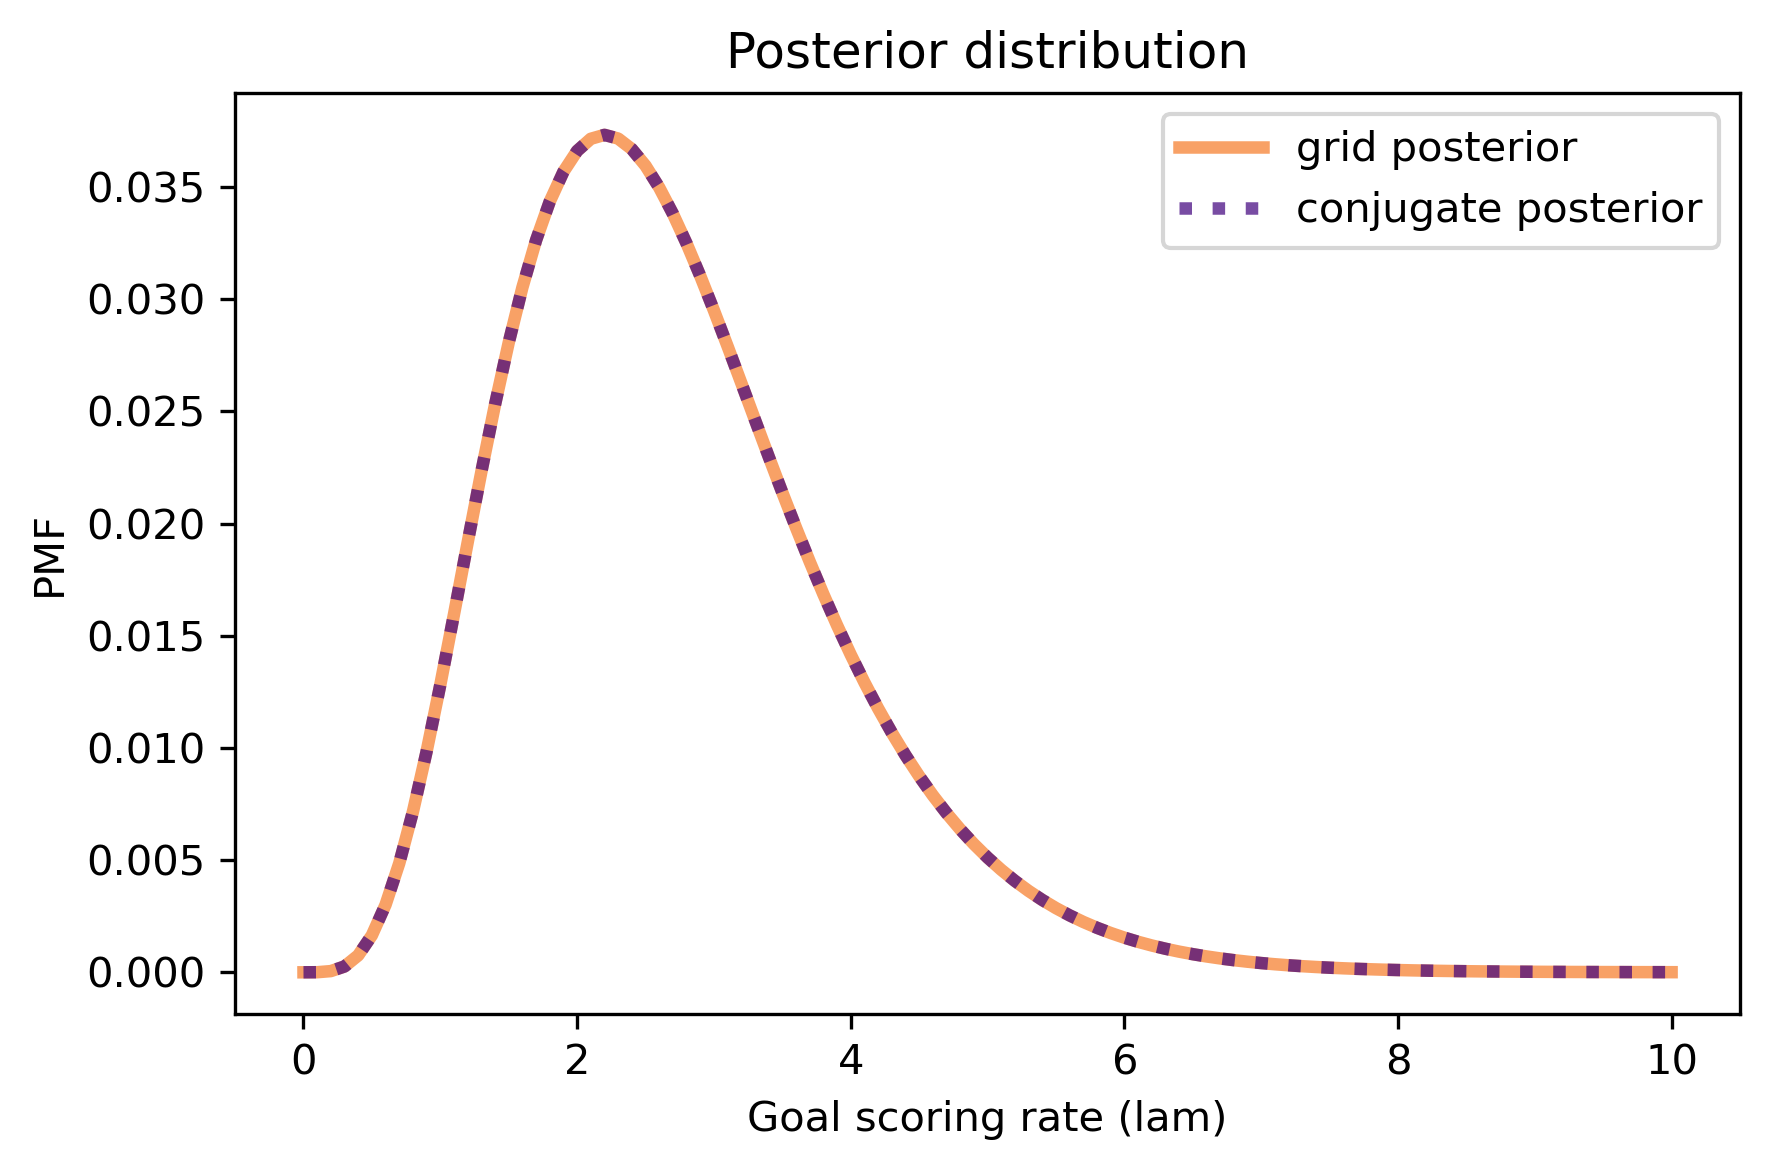

In [14]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior', 
                         color='C4', linestyle='dotted')

decorate_rate('Posterior distribution')

They are the same other than small differences due to floating-point approximations.

In [15]:
np.allclose(posterior, posterior_conjugate)

True

## What the Actual?

To understand how that works, we'll write the PDF of the gamma prior and the PMF of the Poisson likelihood, then multiply them together, because that's what the Bayesian update does.
We'll see that the result is a gamma distribution, and we'll derive its parameters.

Here's the PDF of the gamma prior, which is the probability density for each value of $\lambda$, given parameters $\alpha$ and $\beta$:

$$\lambda^{\alpha-1} e^{-\lambda \beta}$$

I have omitted the normalizing factor; since we are planning to normalize the posterior distribution anyway, we don't really need it.

Now suppose a team scores $k$ goals in $t$ games.
The probability of this data is given by PMF of the Poisson distribution, which is a function of $k$ with $\lambda$ and $t$ as parameters.

$$\lambda^k e^{-\lambda t}$$

Again, I have omitted the normalizing factor, which makes it clearer that the gamma and Poisson distributions have the same functional form.
When we multiply them together, we can pair up the factors and add up the exponents.
The result is the unnormalized posterior distribution,

$$\lambda^{\alpha-1+k} e^{-\lambda(\beta + t)}$$

which we can recognize as an unnormalized gamma distribution with parameters $\alpha + k$ and $\beta + t$.

This derivation provides insight into what the parameters of the posterior distribution mean: $\alpha$ reflects the number of events that have occurred; $\beta$ reflects the elapsed time.

## Binomial Likelihood

As a second example, let's look again at the Euro problem.
When we solved it with a grid algorithm, we started with a uniform prior:

In [16]:
from utils import make_uniform

xs = np.linspace(0, 1, 101)
uniform = make_uniform(xs, 'uniform')

We used the binomial distribution to compute the likelihood of the data, which was 140 heads out of 250 attempts.

In [17]:
from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs
likelihood = binom.pmf(k, n, xs)

Then we computed the posterior distribution in the usual way.

In [18]:
posterior = uniform * likelihood
posterior.normalize()

0.0039446175693263405

We can solve this problem more efficiently using the conjugate prior of the binomial distribution, which is the beta distribution.

The beta distribution is bounded between 0 and 1, so it works well for representing the distribution of a probability like `x`.
It has two parameters, called `alpha` and `beta`, that determine the shape of the distribution.

SciPy provides an object called `beta` that represents a beta distribution.
The following function takes `alpha` and `beta` and returns a new `beta` object.

In [19]:
import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object."""
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

It turns out that the uniform distribution, which we used as a prior, is the beta distribution with parameters `alpha=1` and `beta=1`.
So we can make a `beta` object that represents a uniform distribution, like this:

In [20]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)

Now let's figure out how to do the update.  As in the previous example, we'll write the PDF of the prior distribution and the PMF of the likelihood function, and multiply them together.  We'll see that the product has the same form as the prior, and we'll derive its parameters.

Here is the PDF of the beta distribution, which is a function of $x$ with $\alpha$ and $\beta$ as parameters.

$$x^{\alpha-1} (1-x)^{\beta-1}$$

Again, I have omitted the normalizing factor, which we don't need because we are going to normalize the distribution after the update.

And here's the PMF of the binomial distribution, which is a function of $k$ with $n$ and $x$ as parameters.

$$x^{k} (1-x)^{n-k}$$

Again, I have omitted the normalizing factor.
Now when we multiply the beta prior and the binomial likelihood, the result is

$$x^{\alpha-1+k} (1-x)^{\beta-1+n-k}$$

which we recognize as an unnormalized beta distribution with parameters $\alpha+k$ and $\beta+n-k$.

So if we observe `k` successes in `n` trials, we can do the update by making a beta distribution with parameters `alpha+k` and `beta+n-k`.
That's what this function does:

In [21]:
def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

Again, the conjugate prior gives us insight into the meaning of the parameters; $\alpha$ is related to the number of observed successes; $\beta$ is related to the number of failures.

Here's how we do the update with the observed data.

In [22]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)

To confirm that it works, I'll evaluate the posterior distribution for the possible values of `xs` and put the results in a `Pmf`.

In [23]:
posterior_conjugate = pmf_from_dist(posterior_beta, xs)

And we can compare the posterior distribution we just computed with the results from the grid algorithm.

In [24]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

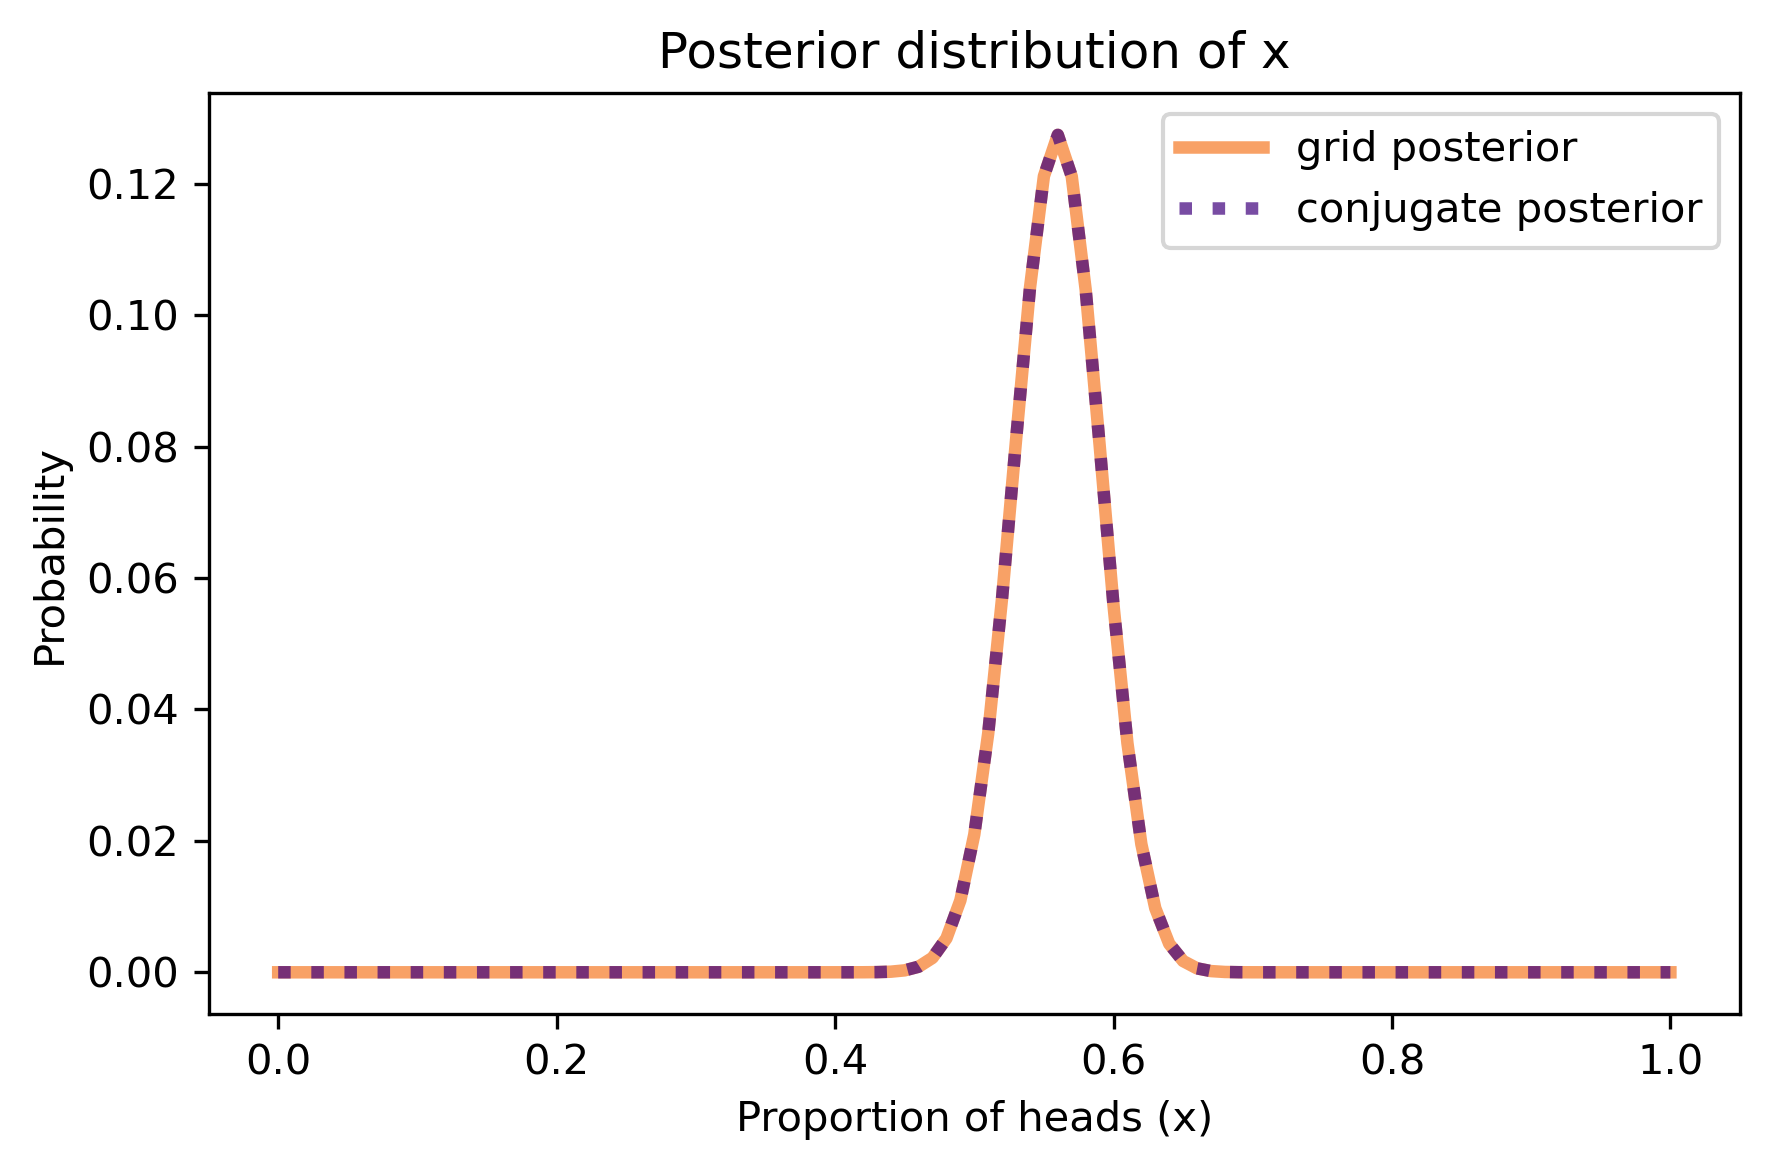

In [25]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior',
                        color='C4', linestyle='dotted')

decorate_euro(title='Posterior distribution of x')

They are the same other than small differences due to floating-point approximations.

The examples so far are problems we have already solved, so let's try something new.

In [26]:
np.allclose(posterior, posterior_conjugate)

True

## Lions and Tigers and Bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, what is the probability that the next animal we see is a bear?

To answer this question, we'll use the data to estimate the prevalence of each species, that is, what fraction of the animals belong to each species.
If we know the prevalences, we can use the multinomial distribution to compute the probability of the data.
For example, suppose we know that the fraction of lions, tigers, and bears is 0.4, 0.3, and 0.3, respectively.

In that case the probability of the data is:

In [27]:
from scipy.stats import multinomial

data = 3, 2, 1
n = np.sum(data)
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

0.10368

Now, we could choose a prior for the prevalences and do a Bayesian update using the multinomial distribution to compute the probability of the data.

But there's an easier way, because the multinomial distribution has a conjugate prior: the Dirichlet distribution.

## The Dirichlet Distribution

The Dirichlet distribution is a multivariate distribution, like the multivariate normal distribution we used in <<_MultivariateNormalDistribution>> to describe the distribution of penguin measurements.  

In that example, the quantities in the distribution are pairs of flipper length and culmen length, and the parameters of the distribution are a vector of means and a matrix of covariances.

In a Dirichlet distribution, the quantities are vectors of probabilities, $\mathbf{x}$, and the parameter is a vector, $\mathbf{\alpha}$.

An example will make that clearer.  SciPy provides a `dirichlet` object that represents a Dirichlet distribution.
Here's an instance with $\mathbf{\alpha} = 1, 2, 3$.

In [28]:
from scipy.stats import dirichlet

alpha = 1, 2, 3
dist = dirichlet(alpha)

Since we provided three parameters, the result is a distribution of three variables.
If we draw a random value from this distribution, like this:

In [29]:
dist.rvs()

array([[0.20907305, 0.43966952, 0.35125743]])

In [30]:
dist.rvs().sum()

1.0000000000000002

The result is an array of three values. 
They are bounded between 0 and 1, and they always add up to 1, so they can be interpreted as the probabilities of a set of outcomes that are mutually exclusive and collectively exhaustive.

Let's see what the distributions of these values look like.  I'll draw 1000 random vectors from this distribution, like this:

In [31]:
sample = dist.rvs(1000)

In [32]:
sample.shape

(1000, 3)

The result is an array with 1000 rows and three columns.  I'll compute the `Cdf` of the values in each column.

In [33]:
from empiricaldist import Cdf

cdfs = [Cdf.from_seq(col) 
        for col in sample.transpose()]

The result is a list of `Cdf` objects that represent the marginal distributions of the three variables.  Here's what they look like.

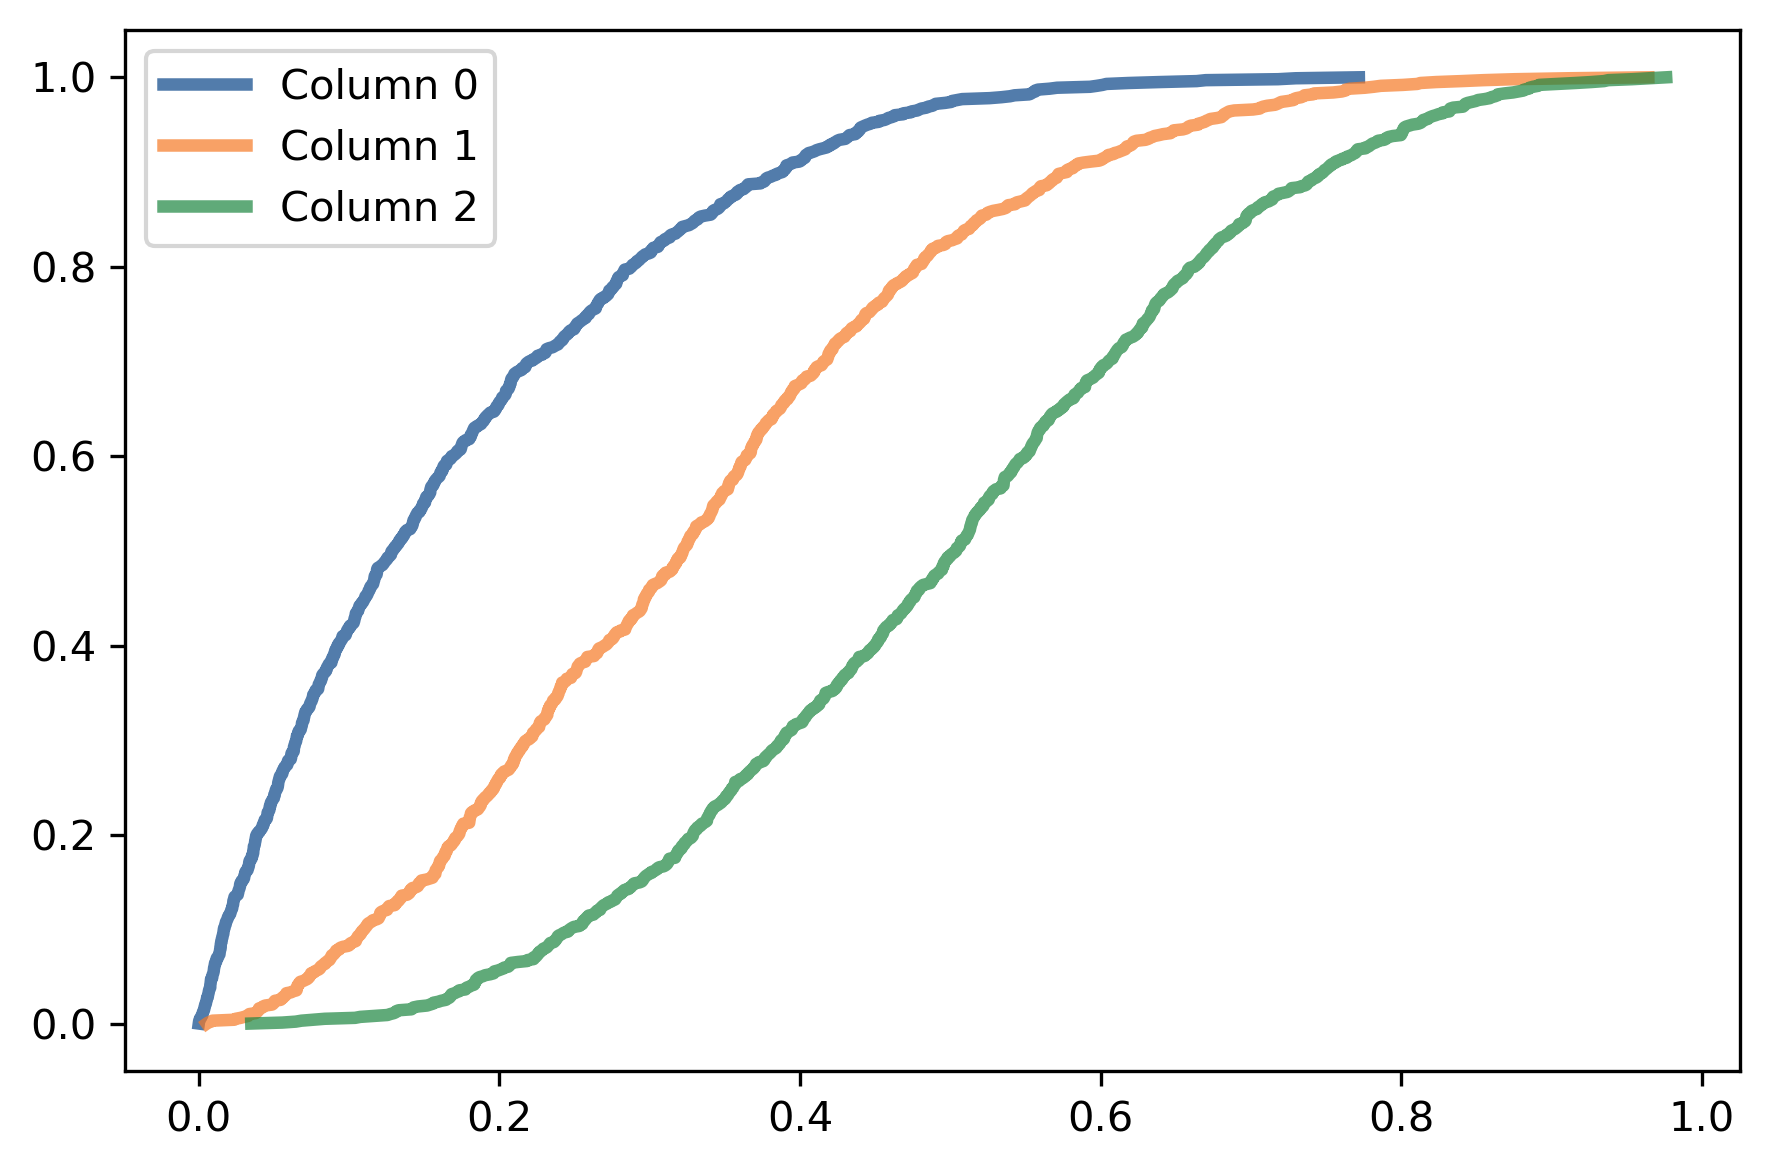

In [34]:
for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    cdf.plot(label=label)
    
decorate()

Column 0, which corresponds to the lowest parameter, contains the lowest probabilities.
Column 2, which corresponds to the highest parameter, contains the highest probabilities.

As it turns out, these marginal distributions are beta distributions.
The following function takes a sequence of parameters, `alpha`, and computes the marginal distribution of variable `i`:

In [35]:
def marginal_beta(alpha, i):
    """Compute the ith marginal of a Dirichlet distribution."""
    total = np.sum(alpha)
    return make_beta(alpha[i], total-alpha[i])

We can use it to compute the marginal distribution for the three variables.

In [36]:
marginals = [marginal_beta(alpha, i)
             for i in range(len(alpha))]

The following plot shows the CDF of these distributions as gray lines and compares them to the CDFs of the samples.

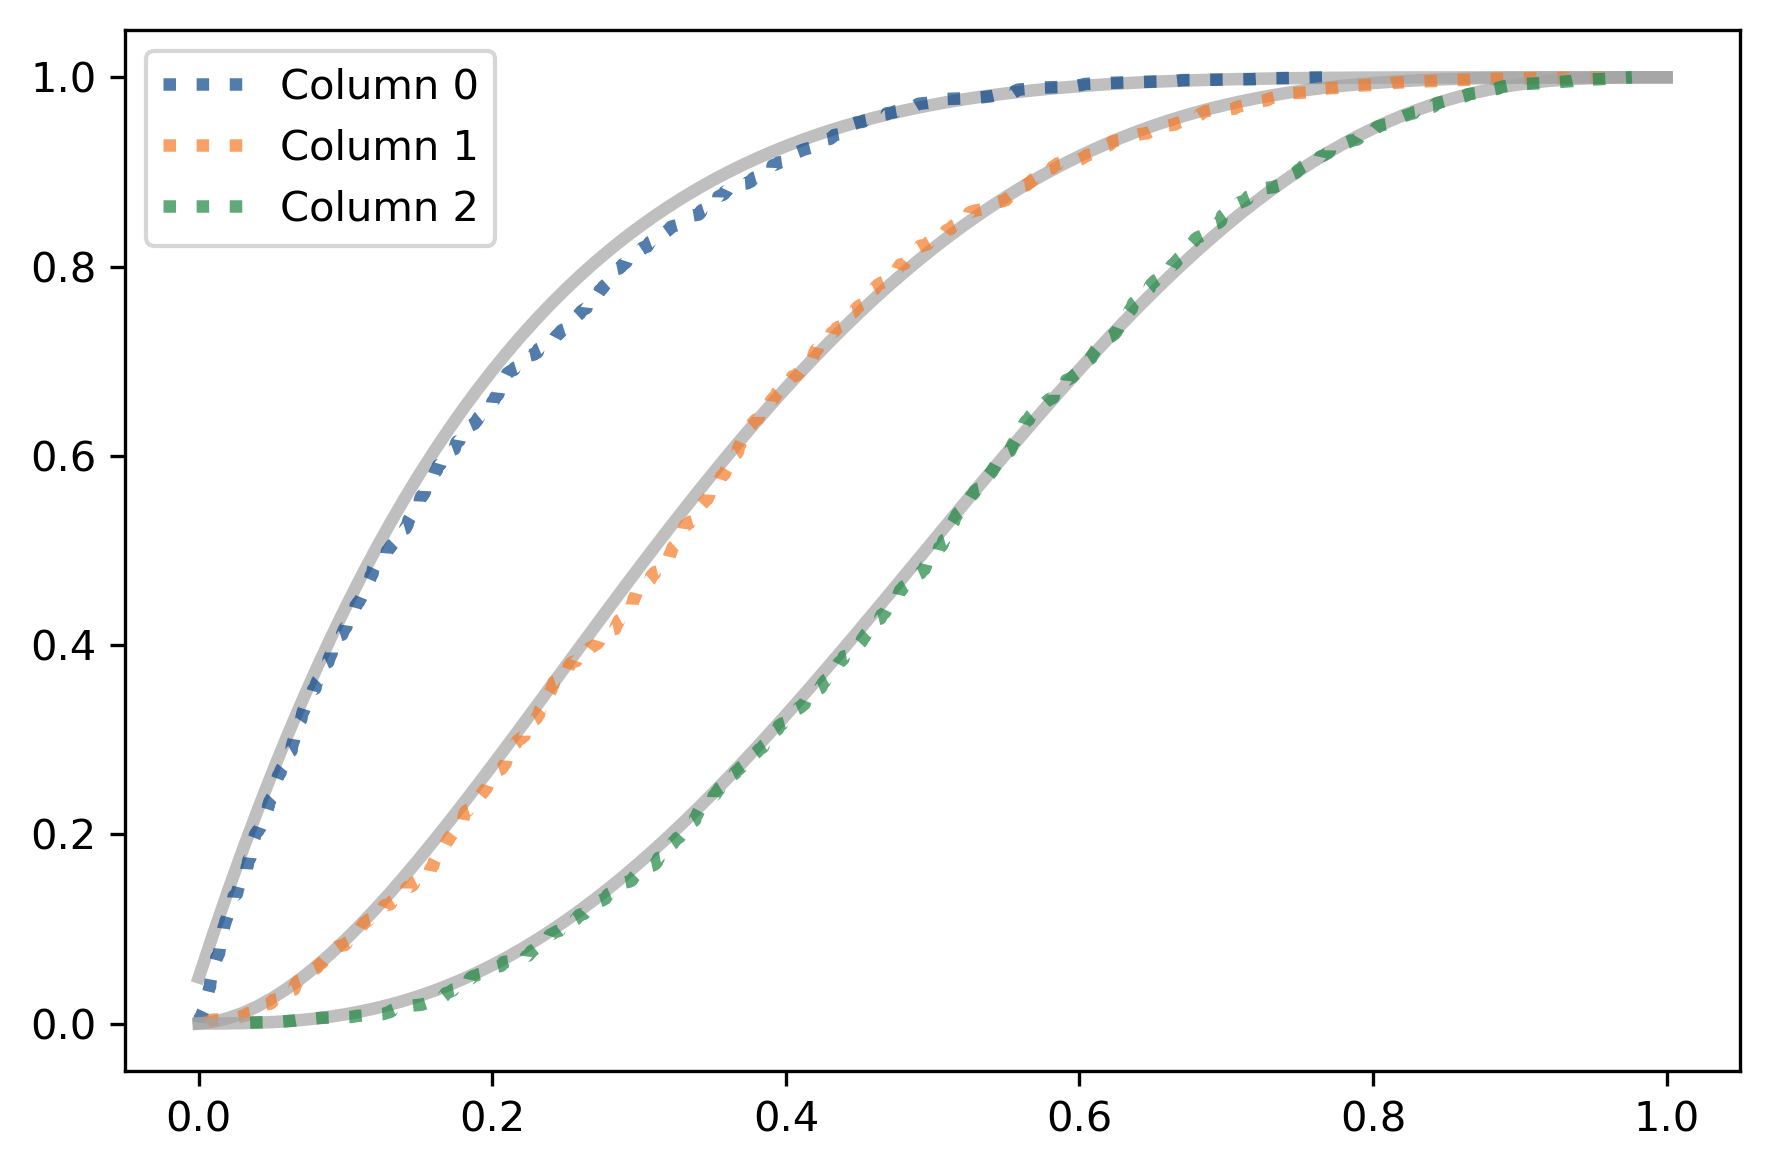

In [37]:
xs = np.linspace(0, 1, 101)

for i in range(len(alpha)):
    label = f'Column {i}'
    
    pmf = pmf_from_dist(marginals[i], xs)
    pmf.make_cdf().plot(color='C5')
    
    cdf = cdfs[i]
    cdf.plot(label=label, style=':')

decorate()

This confirms that the marginals of the Dirichlet distribution are beta distributions.
And that's useful because the Dirichlet distribution is the conjugate prior for the multinomial likelihood function.

If the prior distribution is Dirichlet with parameter vector `alpha` and the data is a vector of observations, `data`, the posterior distribution is Dirichlet with parameter vector `alpha + data`.

As an exercise at the end of this chapter, you can use this method to solve the Lions and Tigers and Bears problem.

## Summary

After reading this chapter, if you feel like you've been tricked, I understand.  It turns out that many of the problems in this book can be solved with just a few arithmetic operations.  So why did we go to all the trouble of using grid algorithms?

Sadly, there are only a few problems we can solve with conjugate priors; in fact, this chapter includes most of the ones that are useful in practice.

For the vast majority of problems, there is no conjugate prior and no shortcut to compute the posterior distribution.
That's why we need grid algorithms and the methods in the next two chapters, Approximate Bayesian Computation (ABC) and Markov chain Monte Carlo methods (MCMC).

## Exercises

**Exercise:** In the second version of the World Cup problem, the data we use for the update is not the number of goals in a game, but the time until the first goal.
So the probability of the data is given by the exponential distribution rather than the Poisson distribution. 

But it turns out that the gamma distribution is *also* the conjugate prior of the exponential distribution, so there is a simple way to compute this update, too.
The PDF of the exponential distribution is a function of $t$ with $\lambda$ as a parameter.

$$\lambda e^{-\lambda t}$$

Multiply the PDF of the gamma prior by this likelihood, confirm that the result is an unnormalized gamma distribution, and see if you can derive its parameters.

Write a few lines of code to update `prior_gamma` with the data from this version of the problem, which was a first goal after 11 minutes and a second goal after an additional 12 minutes.

Remember to express these quantities in units of games, which are approximately 90 minutes.

In [38]:
# Solution

"""
The unnormalized posterior is

\lambda^{\alpha-1+1} e^{-(\beta + t) \lambda}

which is an unnormalized gamma distribution with parameters
`alpha+1` and `beta+t`, which means that we observed 1 goal
in elapsed time `t`.

So we can use the same update function and call it like this:
"""

data = 1, 11/90
posterior1 = update_gamma(prior_gamma, data)

In [39]:
# Solution

# Here's the second update

data = 1, 12/90
posterior2 = update_gamma(posterior1, data)

In [40]:
# Solution

prior_gamma.mean(), posterior1.mean(), posterior2.mean()

(1.4, 2.1386138613861387, 2.7079646017699113)

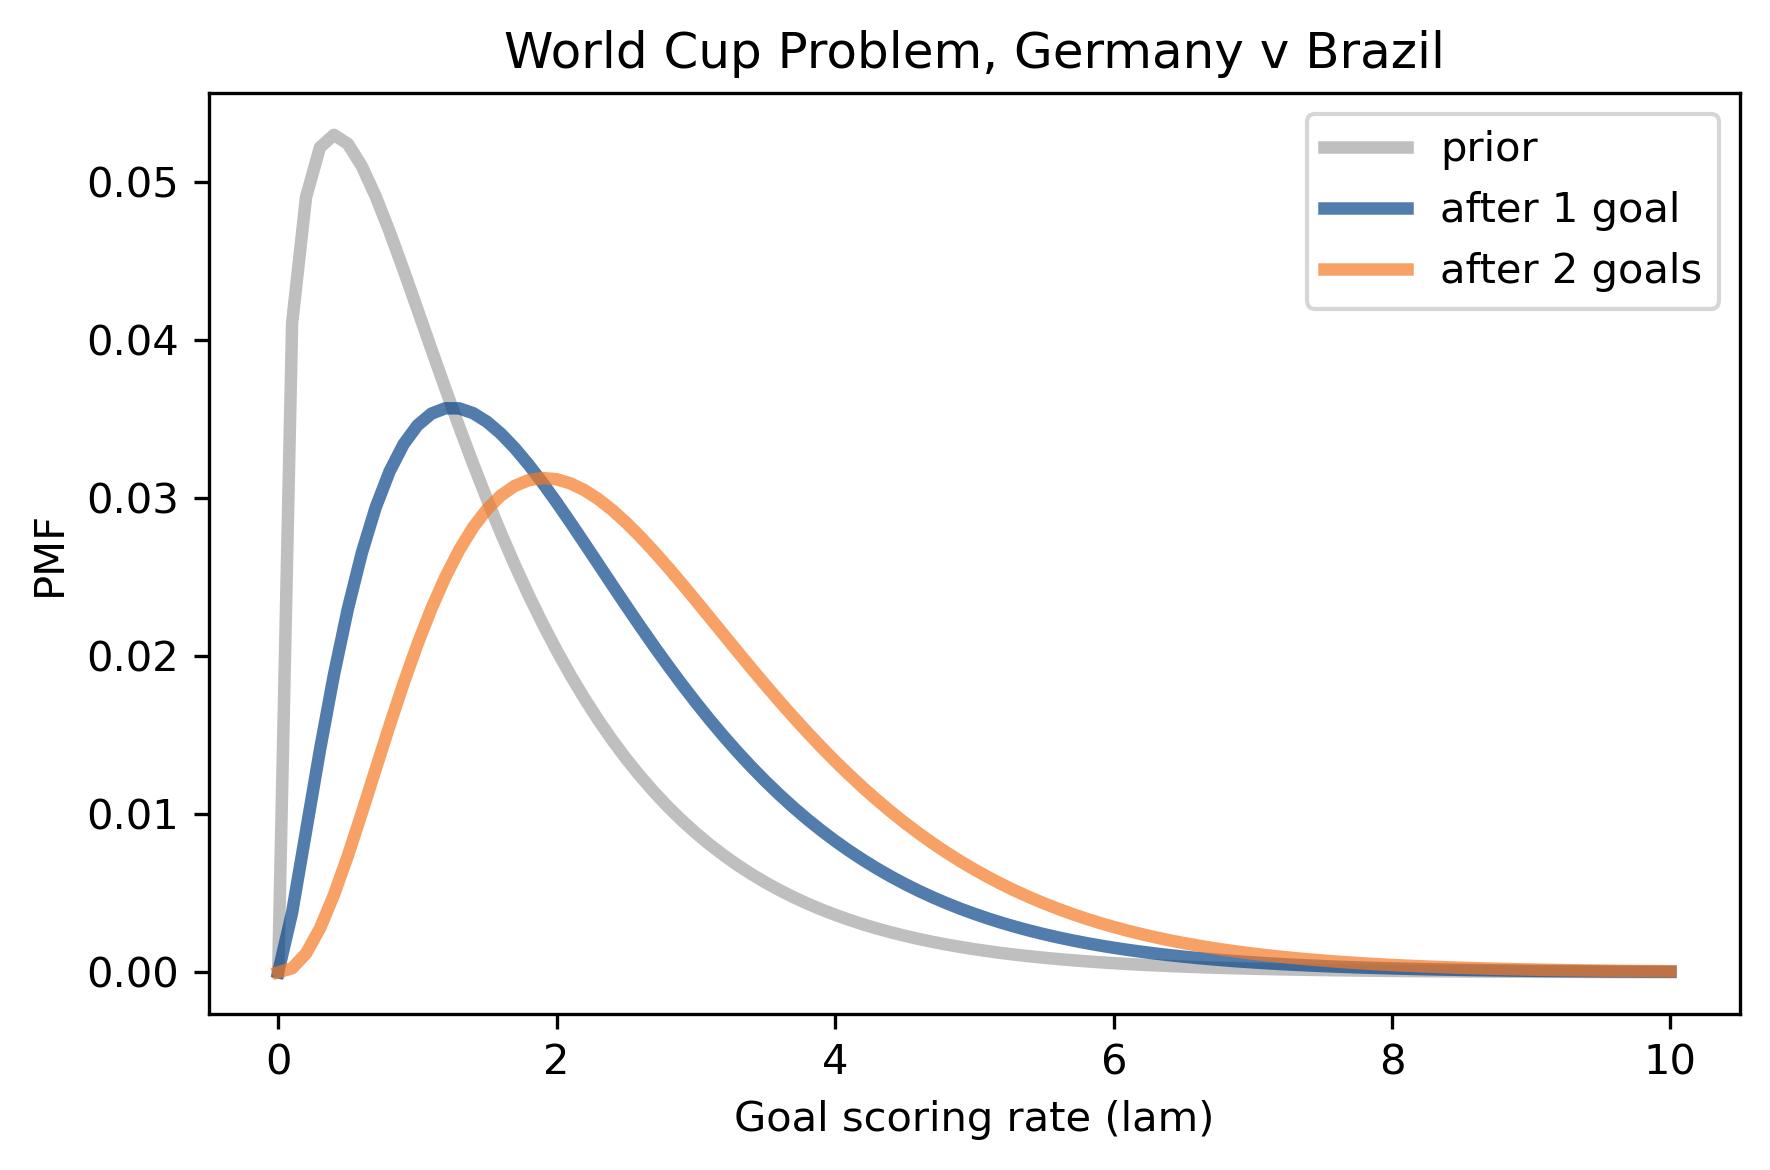

In [41]:
# Solution

# And here's what the posteriors look like

pmf_from_dist(prior_gamma, lams).plot(color='C5', label='prior')
pmf_from_dist(posterior1, lams).plot(label='after 1 goal')
pmf_from_dist(posterior2, lams).plot(label='after 2 goals')

decorate_rate(title='World Cup Problem, Germany v Brazil')

**Exercise:** For problems like the Euro problem where the likelihood function is binomial, we can do a Bayesian update with just a few arithmetic operations, but only if the prior is a beta distribution.

If we want a uniform prior, we can use a beta distribution with `alpha=1` and `beta=1`.
But what can we do if the prior distribution we want is not a beta distribution?
For example, in <<_TrianglePrior>> we also solved the Euro problem with a triangle prior, which is not a beta distribution.

In these cases, we can often find a beta distribution that is a good-enough approximation for the prior we want.
See if you can find a beta distribution that fits the triangle prior, then update it using `update_beta`.

Use `pmf_from_dist` to make a `Pmf` that approximates the posterior distribution and compare it to the posterior we just computed using a grid algorithm.  How big is the largest difference between them?

Here's the triangle prior again.

In [42]:
from empiricaldist import Pmf

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
xs = uniform.qs

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

And here's the update.

In [43]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

posterior = triangle * likelihood
posterior.normalize()

0.0070088425900585345

To get you started, here's the beta distribution that we used as a uniform prior.

In [44]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

0.5

And here's what it looks like compared to the triangle prior.

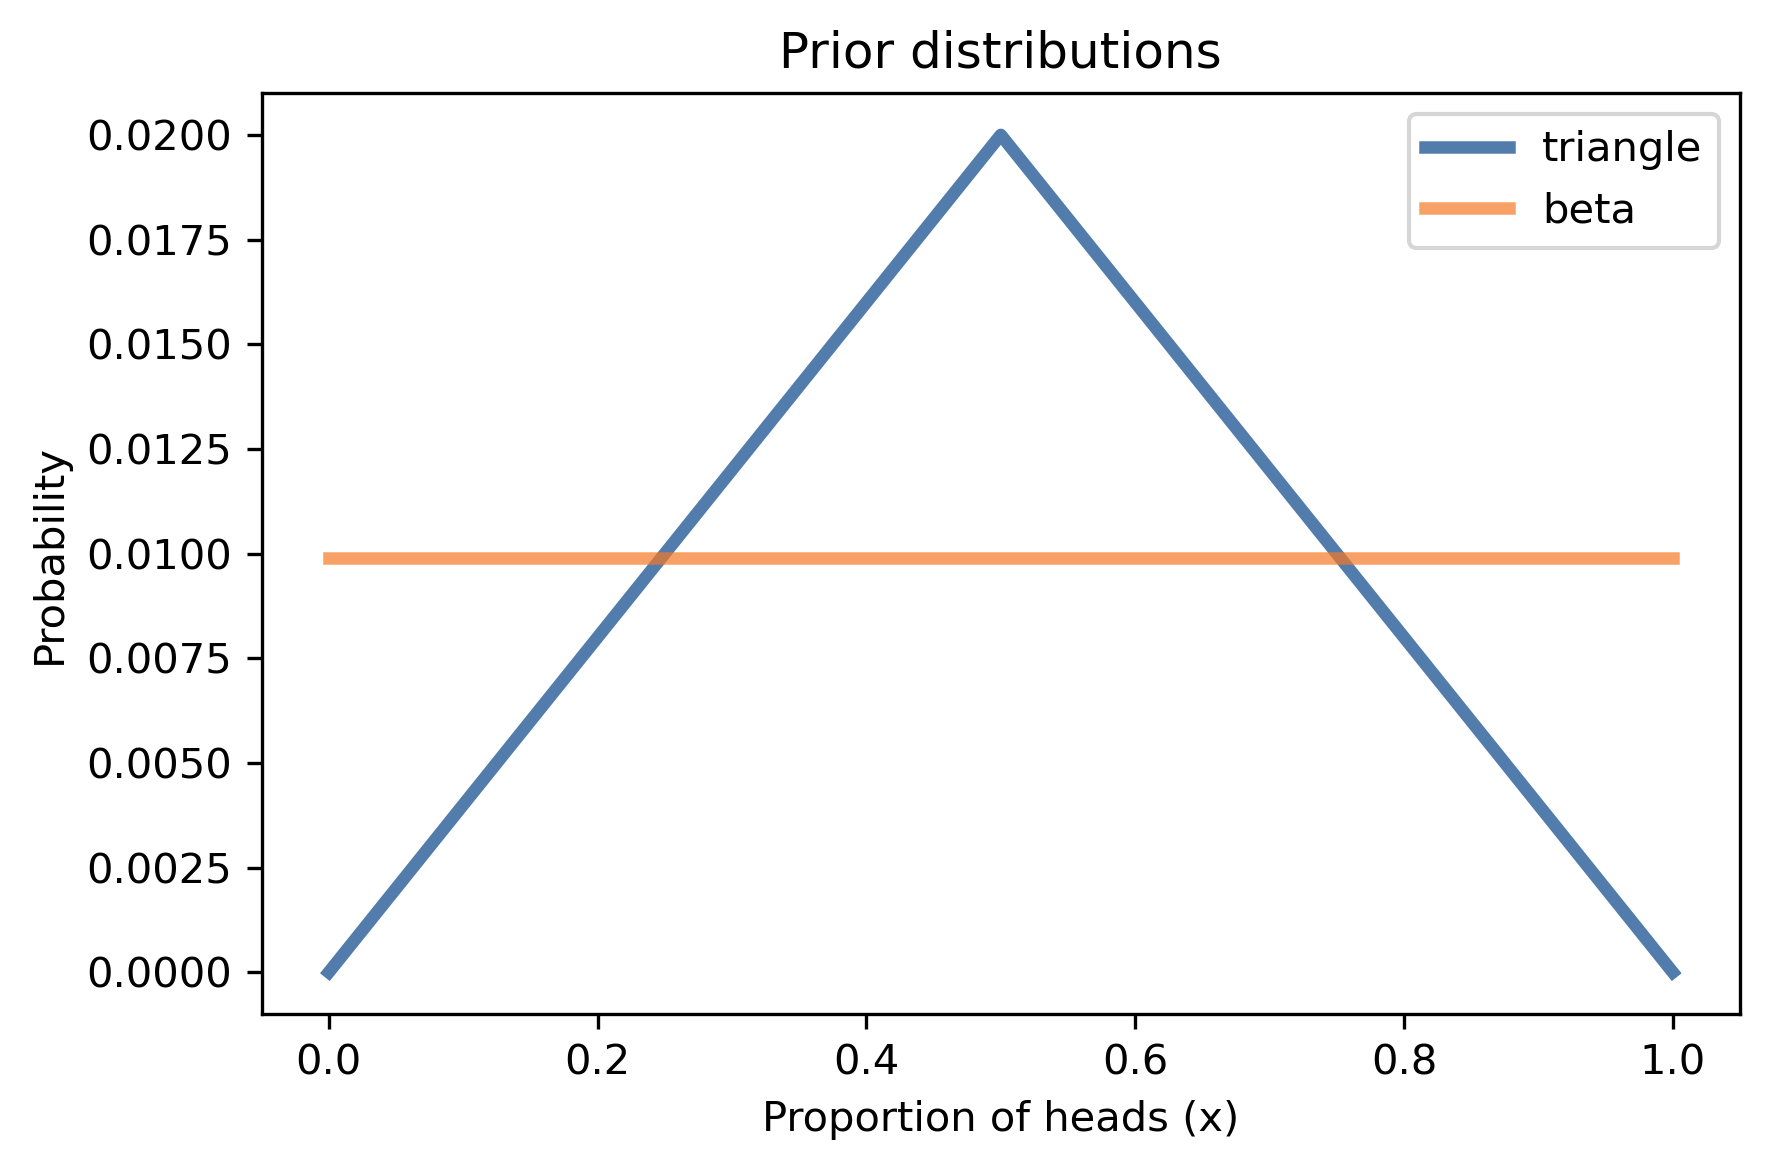

In [45]:
prior_pmf = pmf_from_dist(prior_beta, xs)

triangle.plot(label='triangle')
prior_pmf.plot(label='beta')

decorate_euro('Prior distributions')

Now you take it from there.

In [46]:
# Solution

data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

0.5595238095238095

In [47]:
# Solution

posterior_conjugate = pmf_from_dist(posterior_beta, xs)

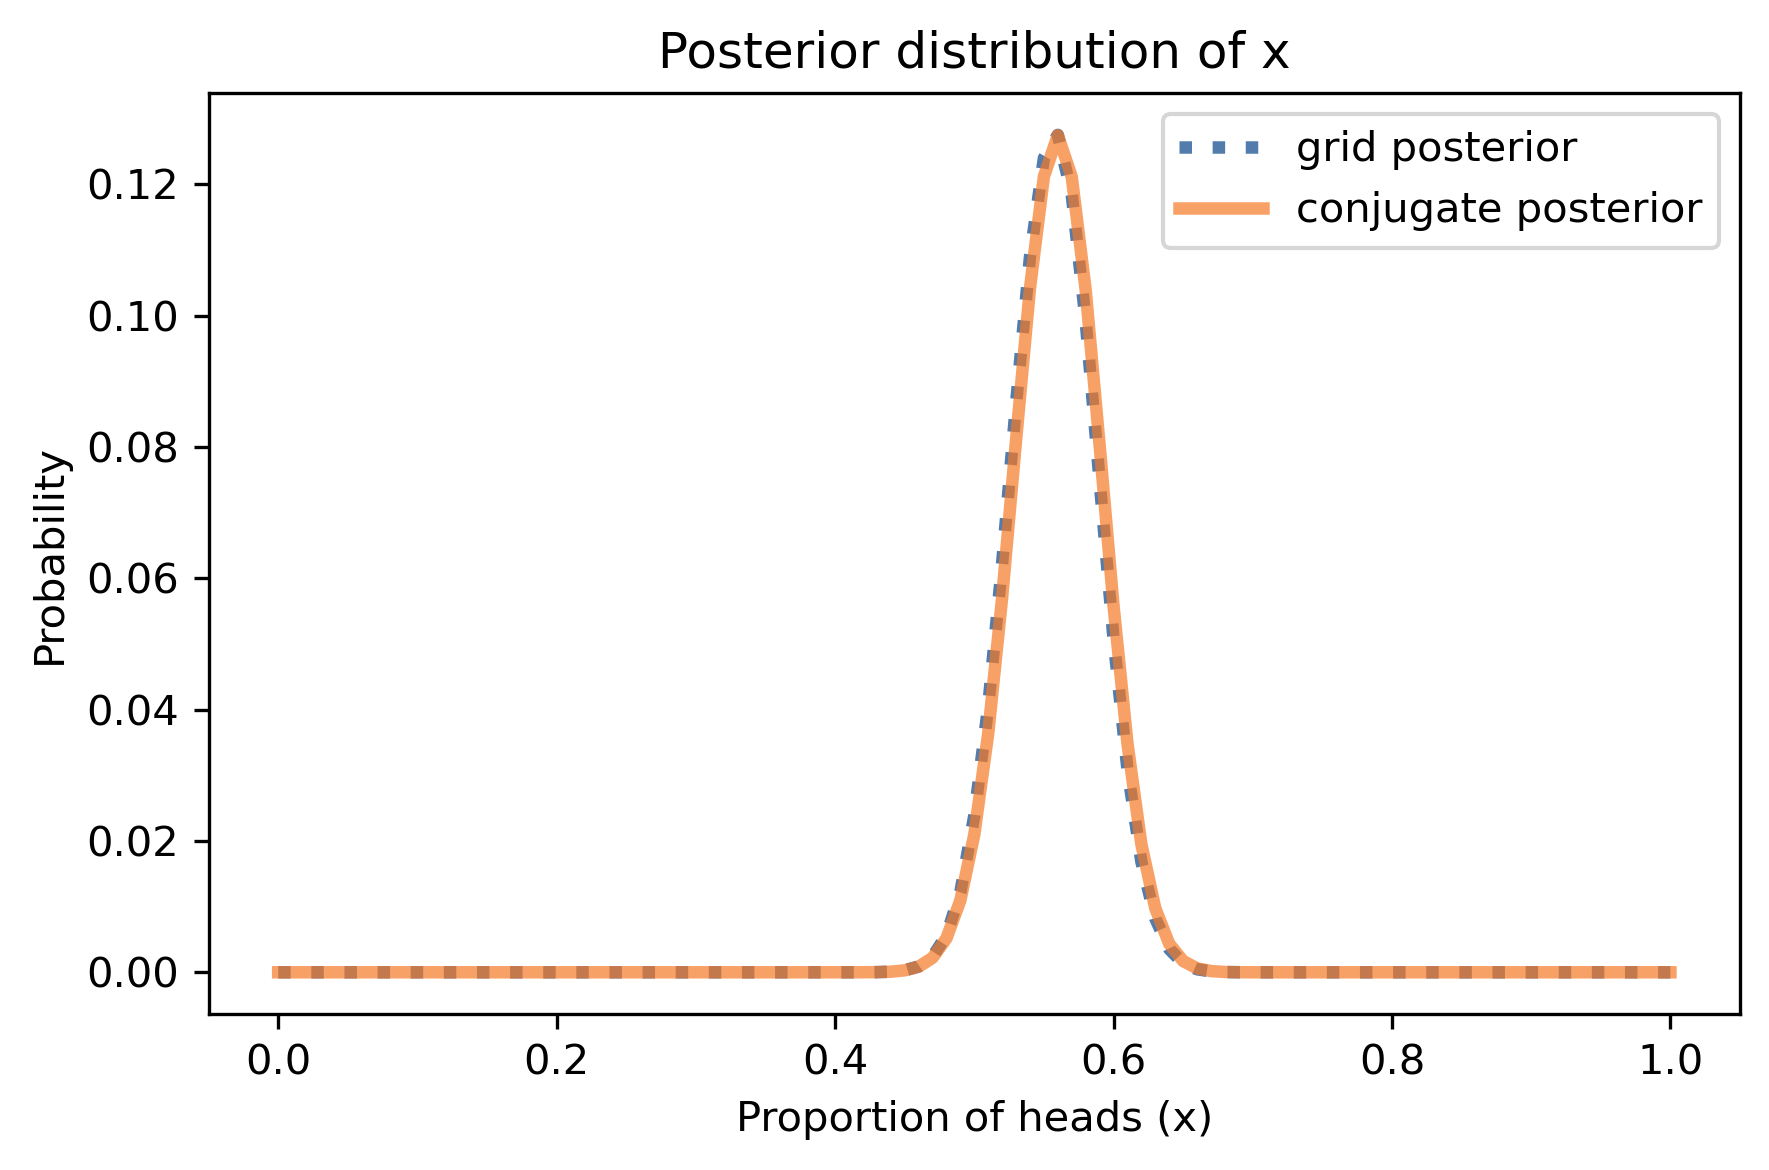

In [48]:
# Solution

posterior.plot(label='grid posterior', linestyle='dotted')
posterior_conjugate.plot(label='conjugate posterior')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Posterior distribution of x')

In [49]:
# Solution

# The largest absolute difference is pretty small

np.allclose(posterior, posterior_conjugate)

False

**Exercise:**  [3Blue1Brown](https://en.wikipedia.org/wiki/3Blue1Brown) is a YouTube channel about math; if you are not already aware of it, I recommend it highly.
In [this video](https://www.youtube.com/watch?v=8idr1WZ1A7Q) the narrator presents this problem:

> You are buying a product online and you see three sellers offering the same product at the same price.  One of them has a 100% positive rating, but with only 10 reviews.  Another has a 96% positive rating with 50 total reviews.  And yet another has a 93% positive rating, but with 200 total reviews.
>
>Which one should you buy from?

Let's think about how to model this scenario.  Suppose each seller has some unknown probability, `x`, of providing satisfactory service and getting a positive rating, and we want to choose the seller with the highest value of `x`.

This is not the only model for this scenario, and it is not necessarily the best.  An alternative would be something like item response theory, where sellers have varying ability to provide satisfactory service and customers have varying difficulty of being satisfied.

But the first model has the virtue of simplicity, so let's see where it gets us.

1. As a prior, I suggest a beta distribution with `alpha=8` and `beta=2`.  What does this prior look like and what does it imply about sellers?

2. Use the data to update the prior for the three sellers and plot the posterior distributions.  Which seller has the highest posterior mean?

3. How confident should we be about our choice?  That is, what is the probability that the seller with the highest posterior mean actually has the highest value of `x`?

4. Consider a beta prior with `alpha=0.7` and `beta=0.5`.  What does this prior look like and what does it imply about sellers?

5. Run the analysis again with the this prior and see what effect it has on the results.

Note: When you evaluate the beta distribution, you should restrict the range of `xs` so it does not include 0 and 1.  When the parameters of the beta distribution are less than 1, the probability density goes to infinity at 0 and 1.  From a mathematical point of view, that's not a problem; it is still a proper probability distribution.  But from a computational point of view, it means we have to avoid evaluating the PDF at 0 and 1. 

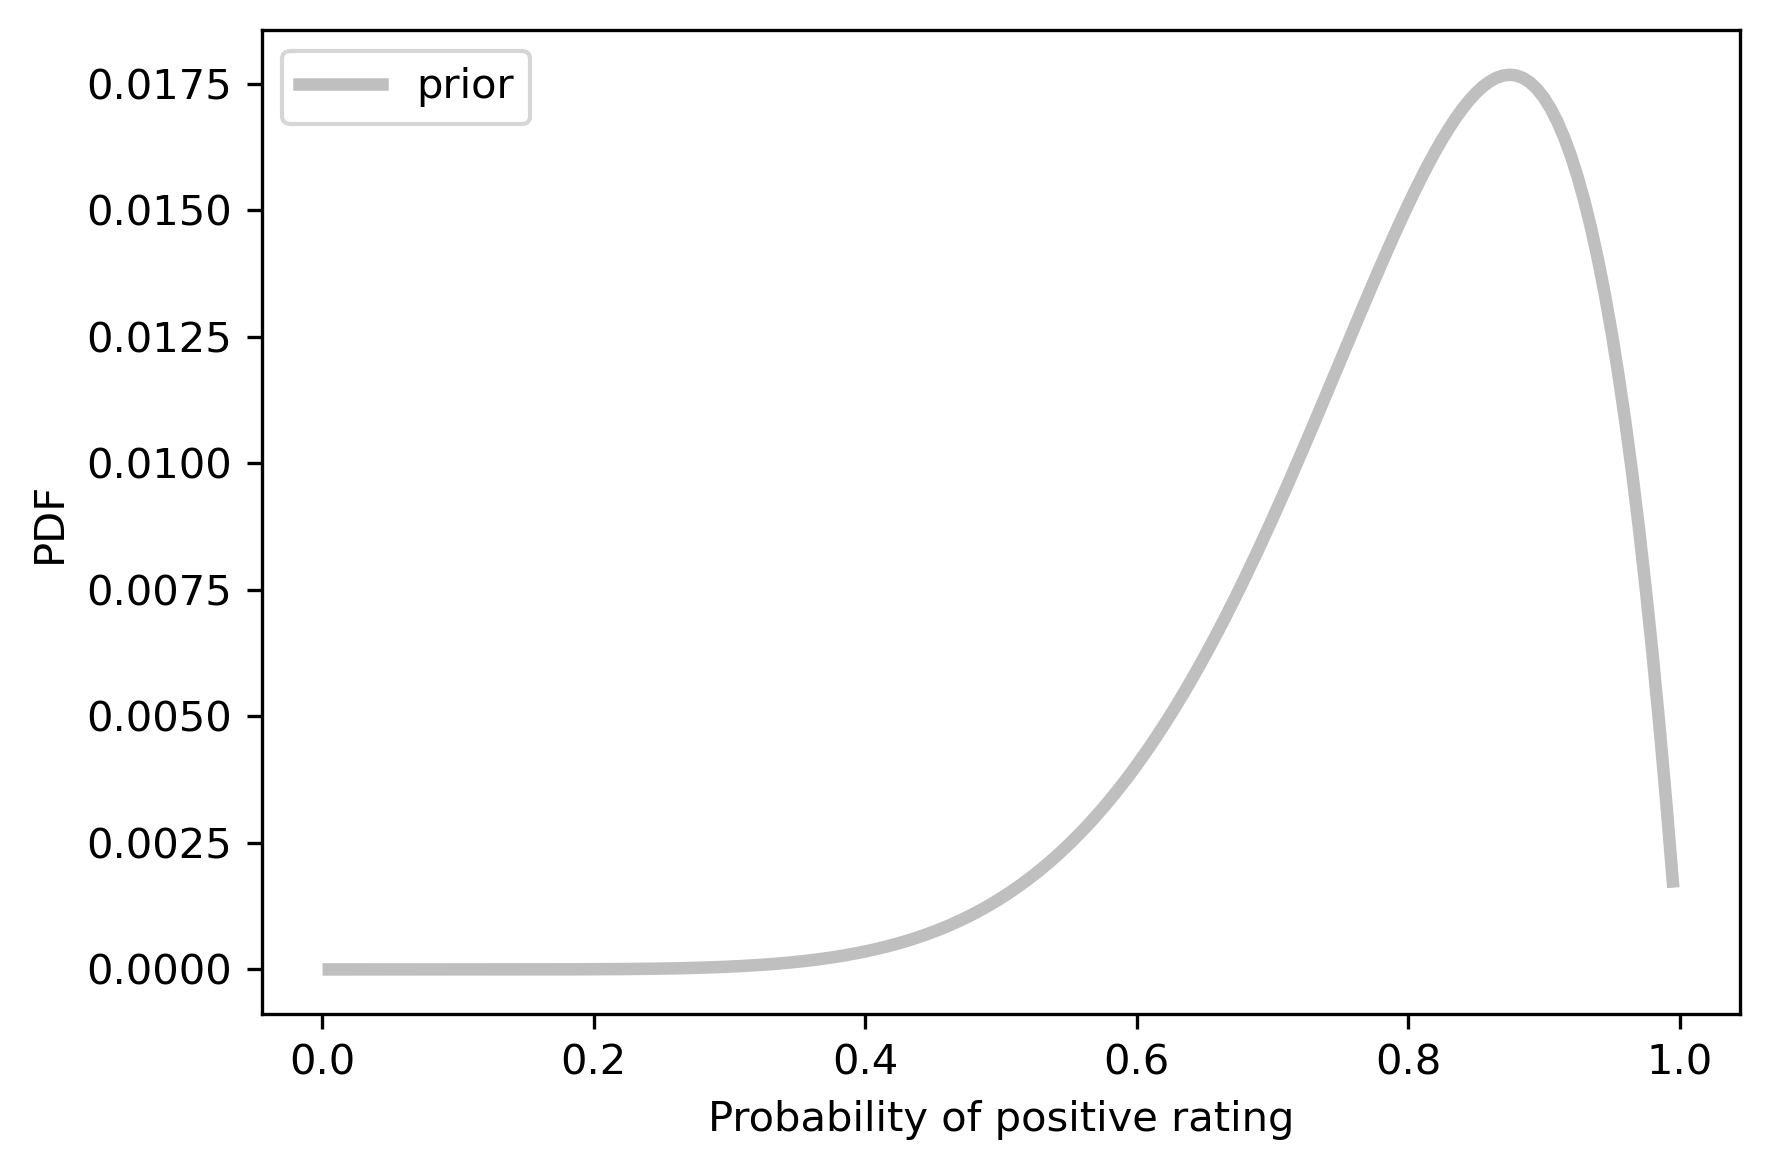

In [50]:
# Solution

# The first prior implies that most sellers are 
# satisfactory most of the time, but none are perfect.

prior = make_beta(8, 2)

xs = np.linspace(0.005, 0.995, 199)
prior_pmf = pmf_from_dist(prior, xs)
prior_pmf.plot(color='C5', label='prior')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF')

In [51]:
# Solution

data1 = 10, 10
data2 = 48, 50
data3 = 186, 200

In [52]:
# Solution

seller1 = update_beta(prior, data1)
seller2 = update_beta(prior, data2)
seller3 = update_beta(prior, data3)

In [53]:
# Solution

seller1_pmf = pmf_from_dist(seller1, xs)
seller2_pmf = pmf_from_dist(seller2, xs)
seller3_pmf = pmf_from_dist(seller3, xs)

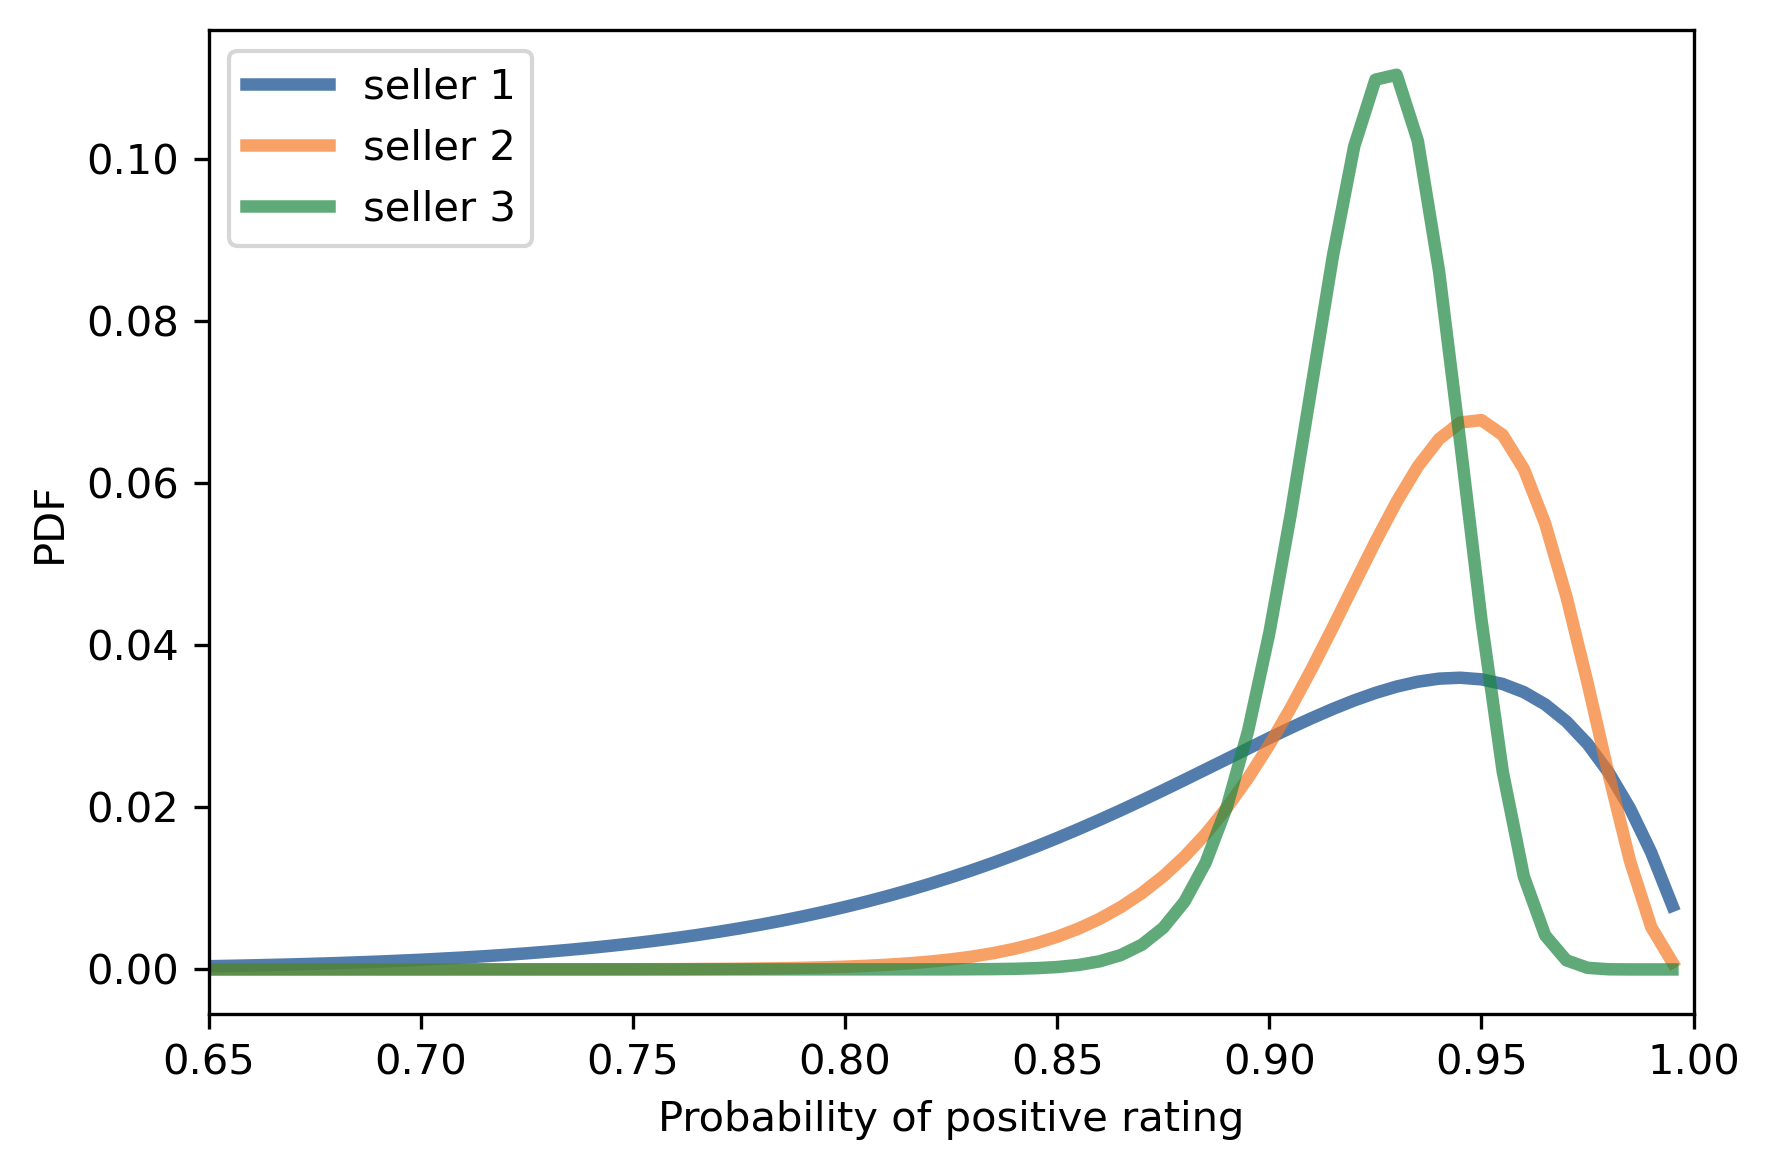

In [54]:
# Solution

seller1_pmf.plot(label='seller 1')
seller2_pmf.plot(label='seller 2')
seller3_pmf.plot(label='seller 3')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF',
         xlim=(0.65, 1.0))

In [55]:
# Solution

seller1.mean(), seller2.mean(), seller3.mean()

(0.9, 0.9333333333333333, 0.9238095238095239)

In [56]:
# Solution

iters = 10000
a = np.empty((3, iters))

a[0] = seller1.rvs(iters)
a[1] = seller2.rvs(iters)
a[2] = seller3.rvs(iters)

In [57]:
# Solution

from empiricaldist import Pmf

best = np.argmax(a, axis=0)
Pmf.from_seq(best)

,probs
0,0.2876
1,0.4735
2,0.2389


**Exercise:** Use a Dirichlet prior with parameter vector `alpha = [1, 1, 1]` to solve the Lions and Tigers and Bears problem:

>Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
>
>During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.
>
>What is the probability that the next animal we see is a bear?


In [58]:
# Solution

prior_alpha = np.array([1, 1, 1])
data = 3, 2, 1

In [59]:
# Solution

posterior_alpha = prior_alpha + data

In [60]:
# Solution

marginal_bear = marginal_beta(posterior_alpha, 2)
marginal_bear.mean()

0.2222222222222222

In [61]:
# Solution

dist = dirichlet(posterior_alpha)

In [62]:
# Solution

import pandas as pd

index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.444444
tiger,0.333333
bear,0.222222
